In [ ]:
#If running under collab, uncomment and run this cell.

#!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
#!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
#!apt-get update
#!apt-get install python3-graph-tool python3-matplotlib python3-cairo
#!apt purge python3-cairo
#!apt install libcairo2-dev pkg-config python3-dev
#!pip install --force-reinstall pycairo
#!pip install zstandard
#!mkdir data
#!wget -nc https://raw.githubusercontent.com/snma-tutorial/www2023/main/exercises/data/example.gt.gz -P data/
    

Homophily and triadic closure inference with graph-tool
==============================================

https://graph-tool.skewed.de/

You should familiarize yourself with ``graph-tool`` by reading the quick start guide: https://graph-tool.skewed.de/static/doc/quickstart.html

A detailed HOWTO for network inference is available at: https://graph-tool.skewed.de/static/doc/demos/inference/inference.html

In [1]:
from graph_tool.all import *
import numpy

In [ ]:
# load a simple example network

g = collection.ns["facebook_friends"]
graph_draw(g, g.vp._pos);

In [3]:
# We can infer homophily by fitting a “planted partition” SBM
state = PPBlockState(g)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);

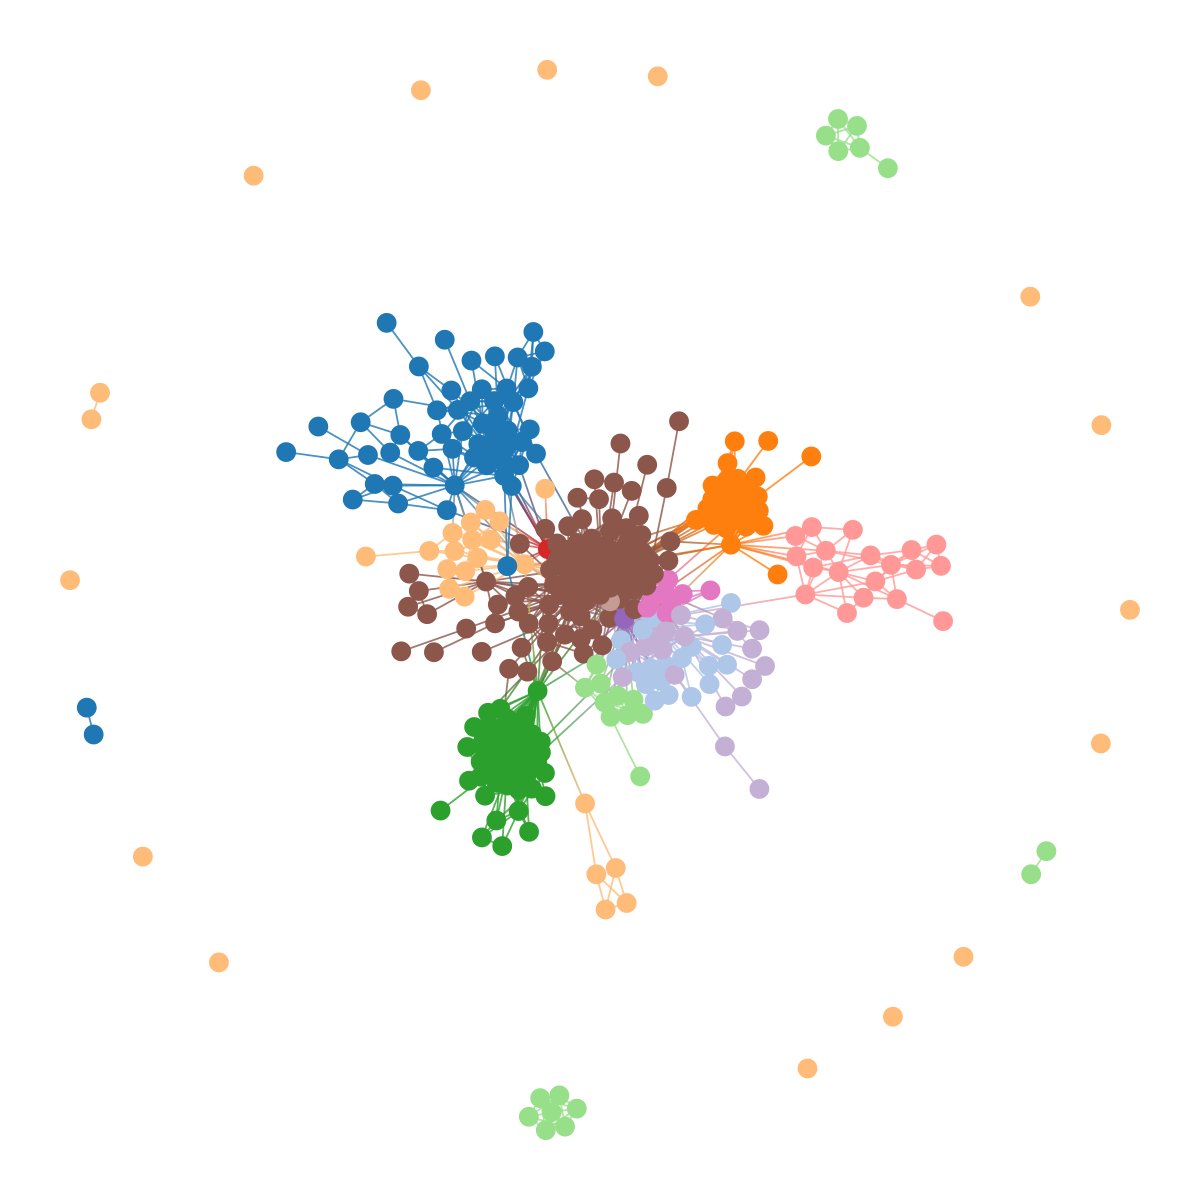

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc86378e190, at 0x7fc863673f70>

In [4]:
# let's visualize the inferred latent homophilic classes as colors:
state.draw(pos=g.vp._pos)

# Evaluating uncertainty
What is the probability that node belongs to a group?

In [5]:
# Let's evaluate the uncertainty of our inference

state.multiflip_mcmc_sweep(niter=1000)
bs = [] # we will collect many partitions here
for i in range(1000):
    state.multiflip_mcmc_sweep(niter=10)
    bs.append(state.b.a.copy())
ps = PartitionModeState(bs, converge=True)  # this will take care of aligning the group labels
pv = ps.get_marginal(g)

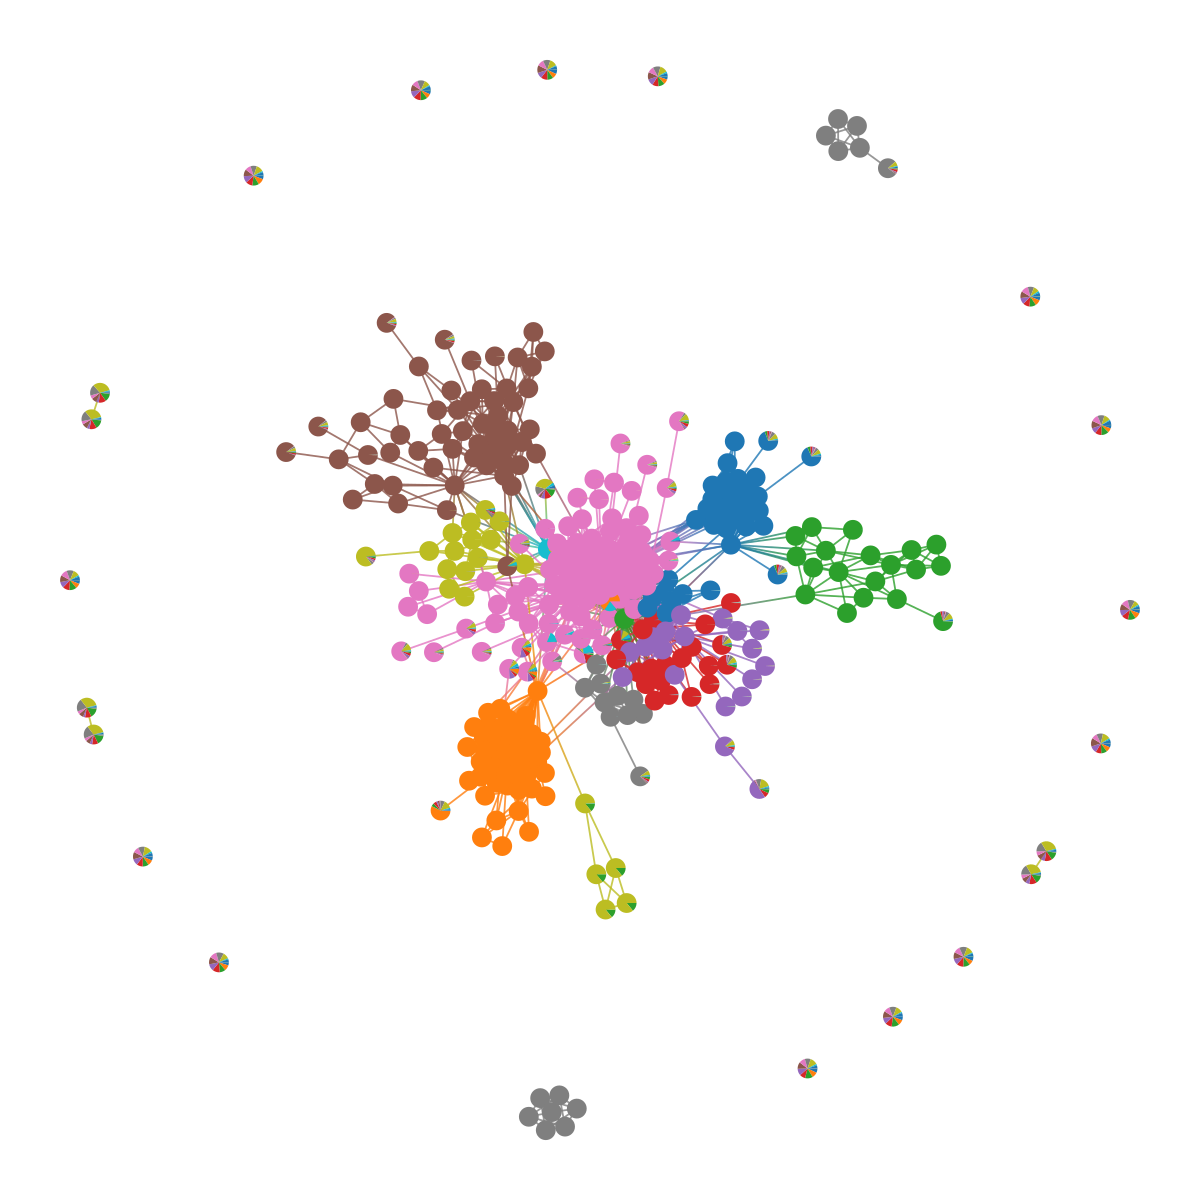

In [6]:
state.draw(pos=g.vp._pos, vertex_shape="pie", vertex_pie_fractions=pv);

## Exercise

Consider the following network:

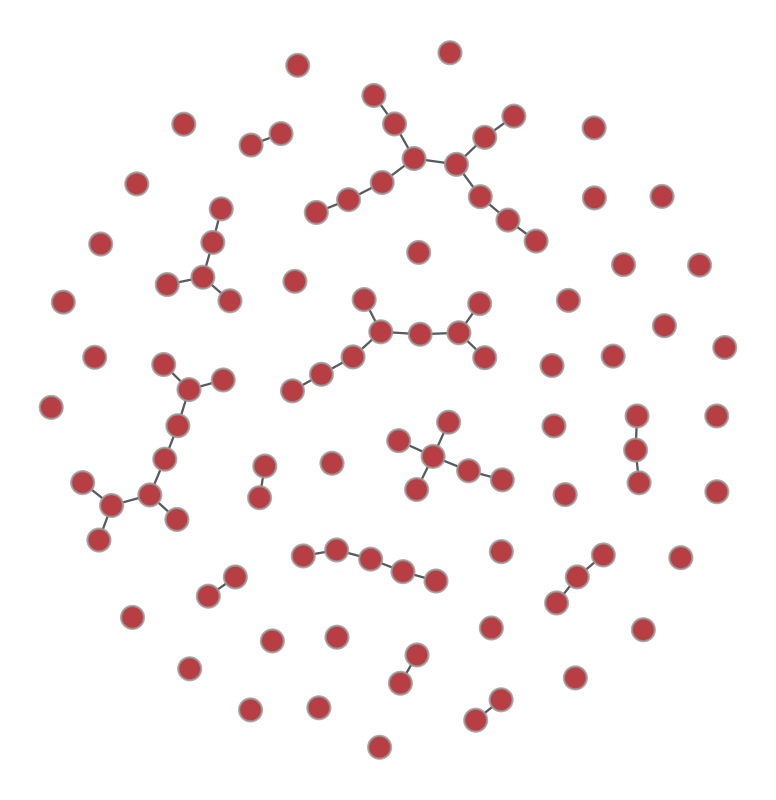

In [7]:
g = load_graph("data/example.gt.gz")
graph_draw(g, pos=g.vp.pos, output_size=(400, 400));

1. Just by looking at the drawing, without running any code, can you guess how many homphilic groups/communities are there in this network?
2. Compare your guess with what you find for the SBM.
3. Compare the previous result with modularity maximization. (You can do modularity maximization with graph-tool just like with the SBM, but using instead a ``ModularityState`` object, which behaves like a ``PPBlockState`` object.)
4. Which result do you prefer? Can you justifythem?

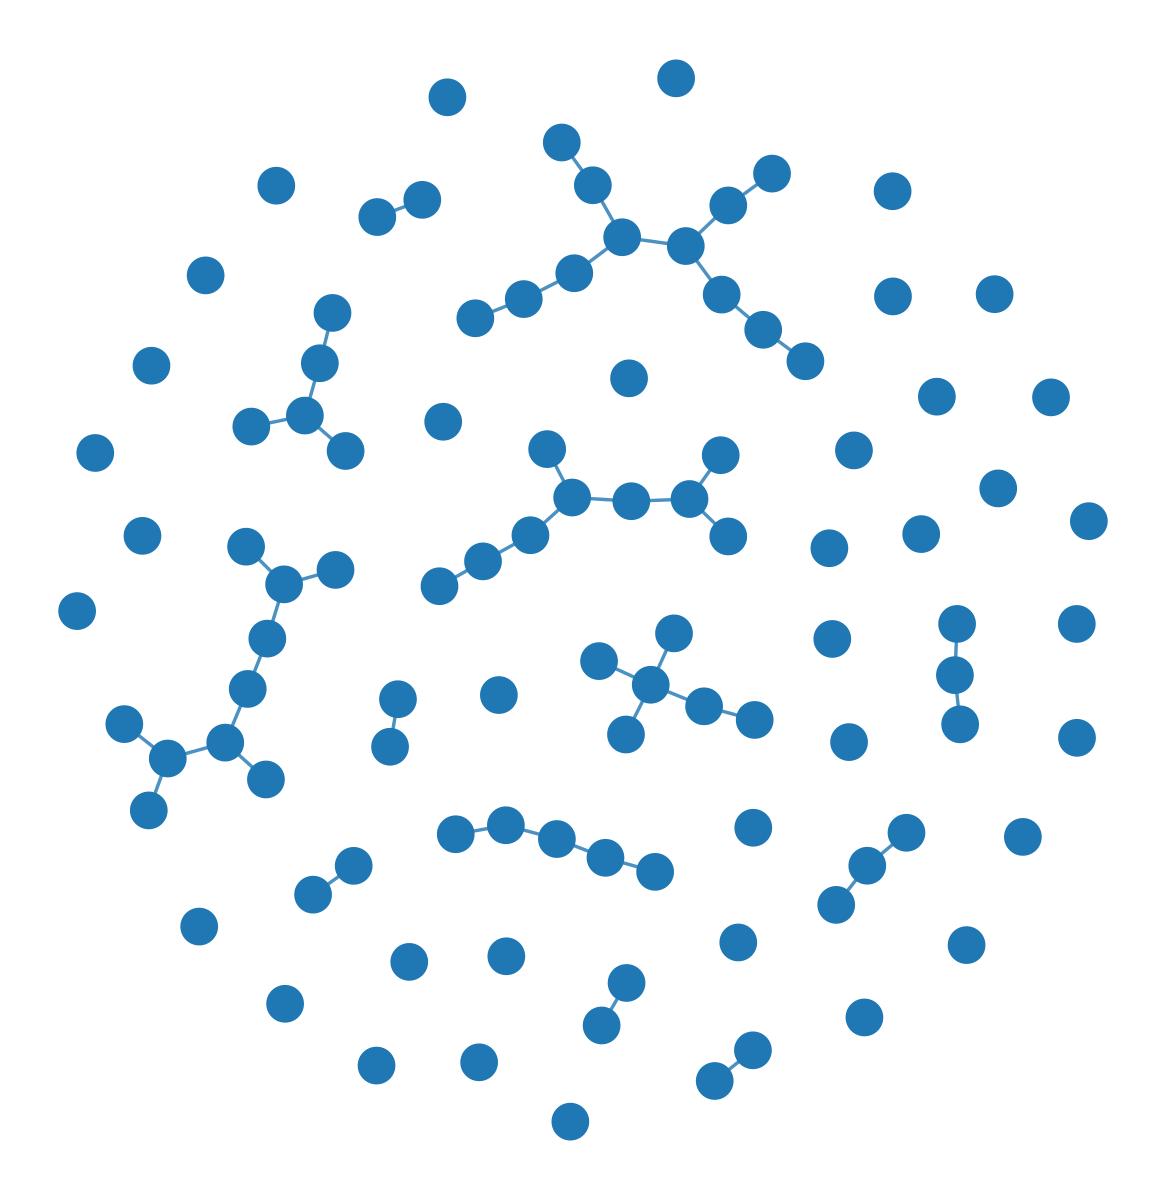

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc863696bb0, at 0x7fc863792700>

In [8]:
state = PPBlockState(g)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=g.vp.pos)

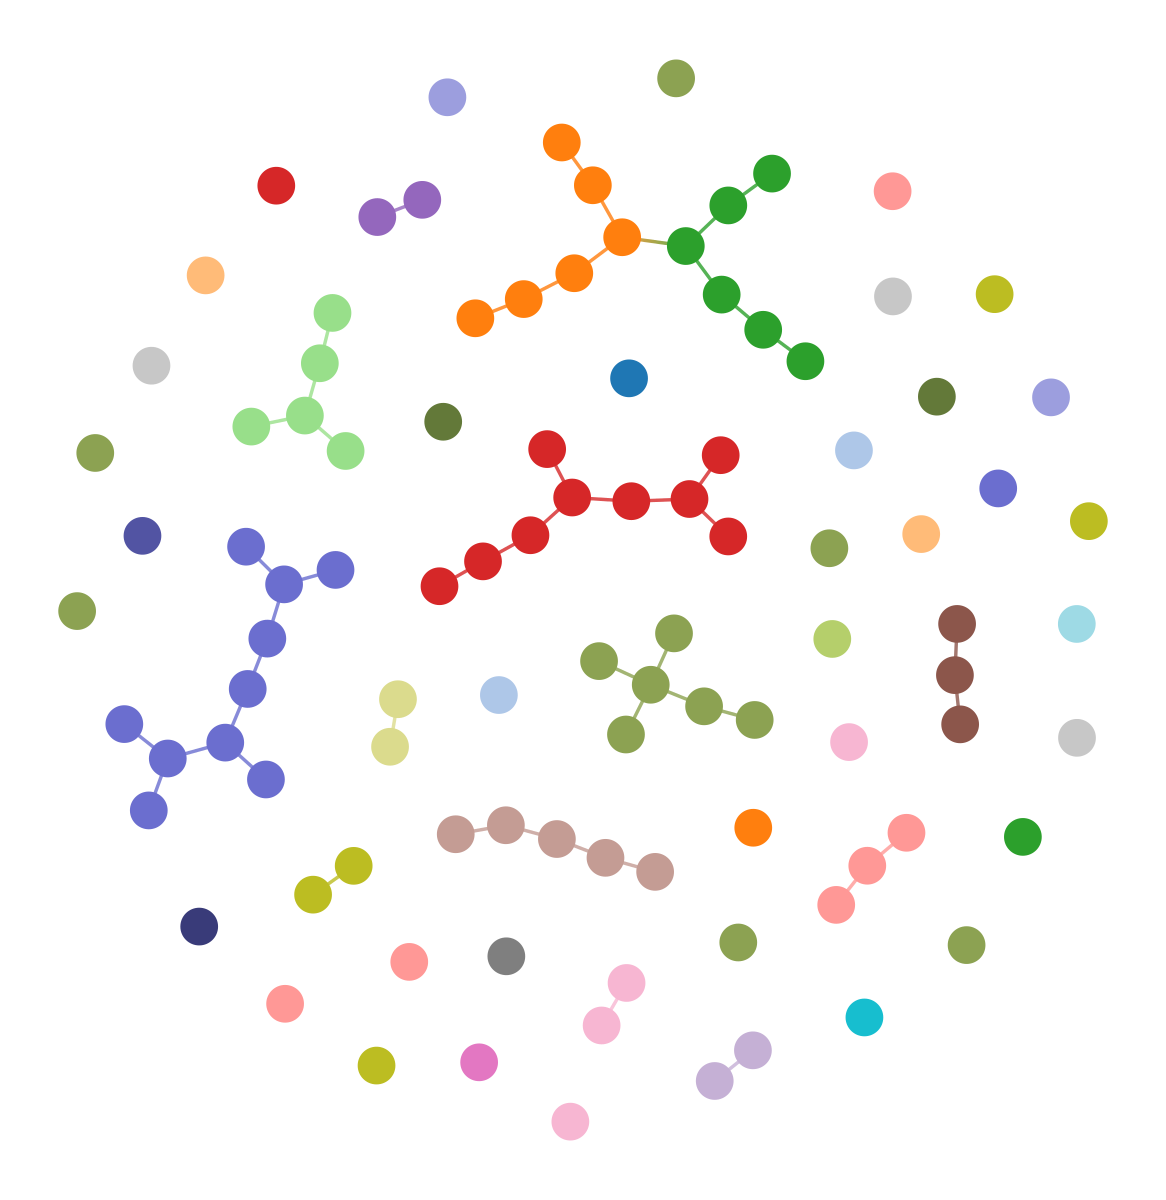

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc8637920a0, at 0x7fc863792b50>

In [9]:
state = ModularityState(g)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=g.vp.pos)

### Exercise

Consider the following network:




In [10]:
g = collection.data["football"]
u = g.copy()
random_rewire(u, n_iter=100); # u is now a random graph with the same degrees as g

1. Find the groups/communities using the SBM for ``g`` and ``u``.
2. Do the same using modularity maximization.
3. How many groups do you find in each case? Can you interpret the results?

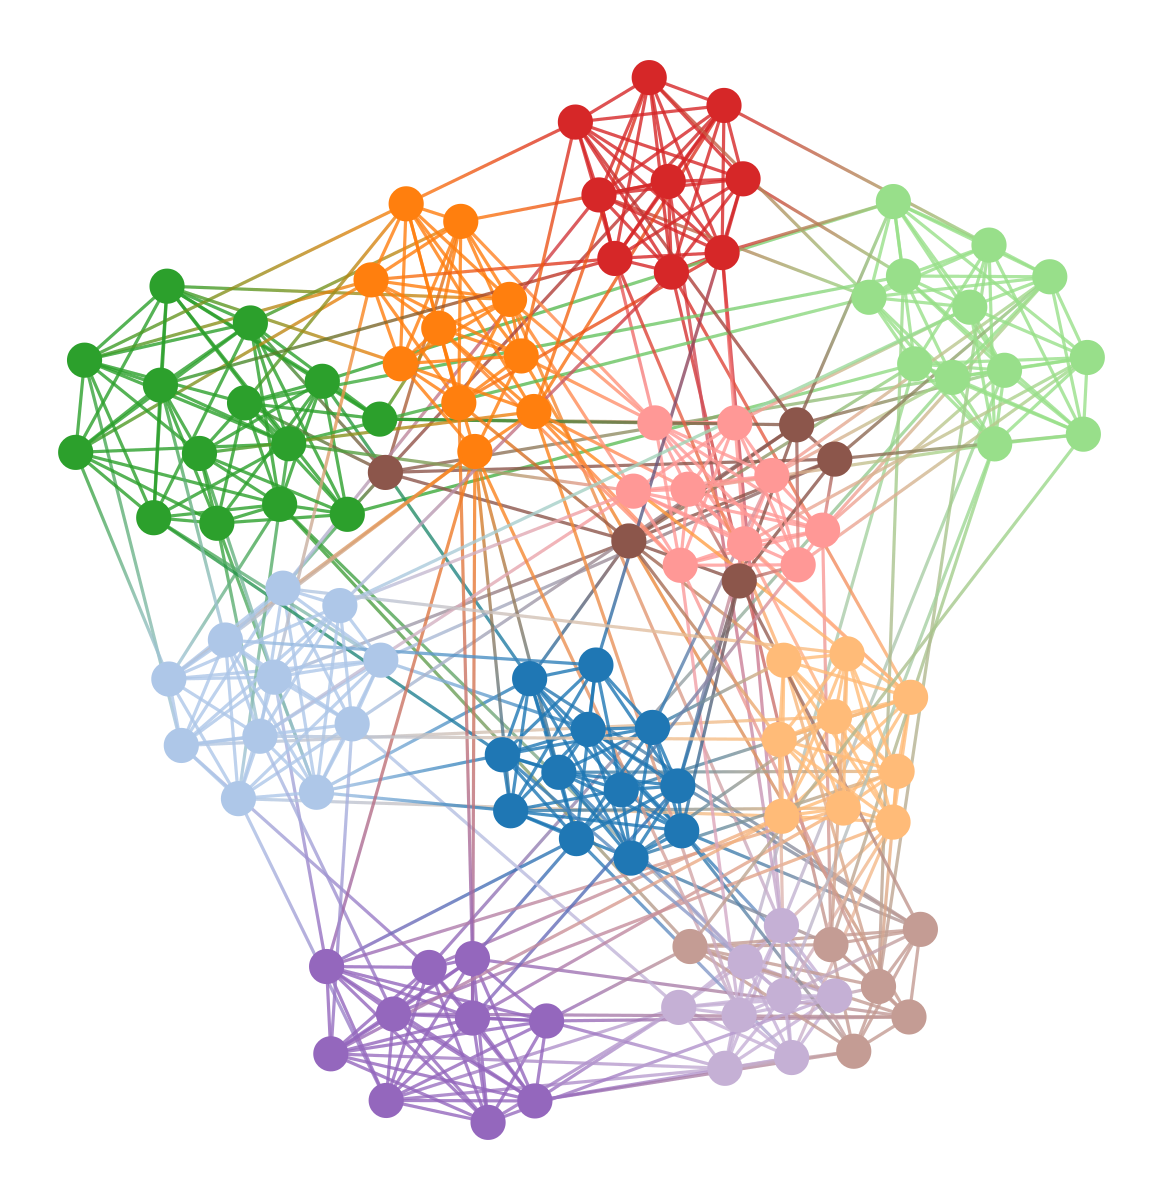

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc8636dfbe0, at 0x7fc863792220>

In [11]:
state = PPBlockState(g)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=g.vp.pos)

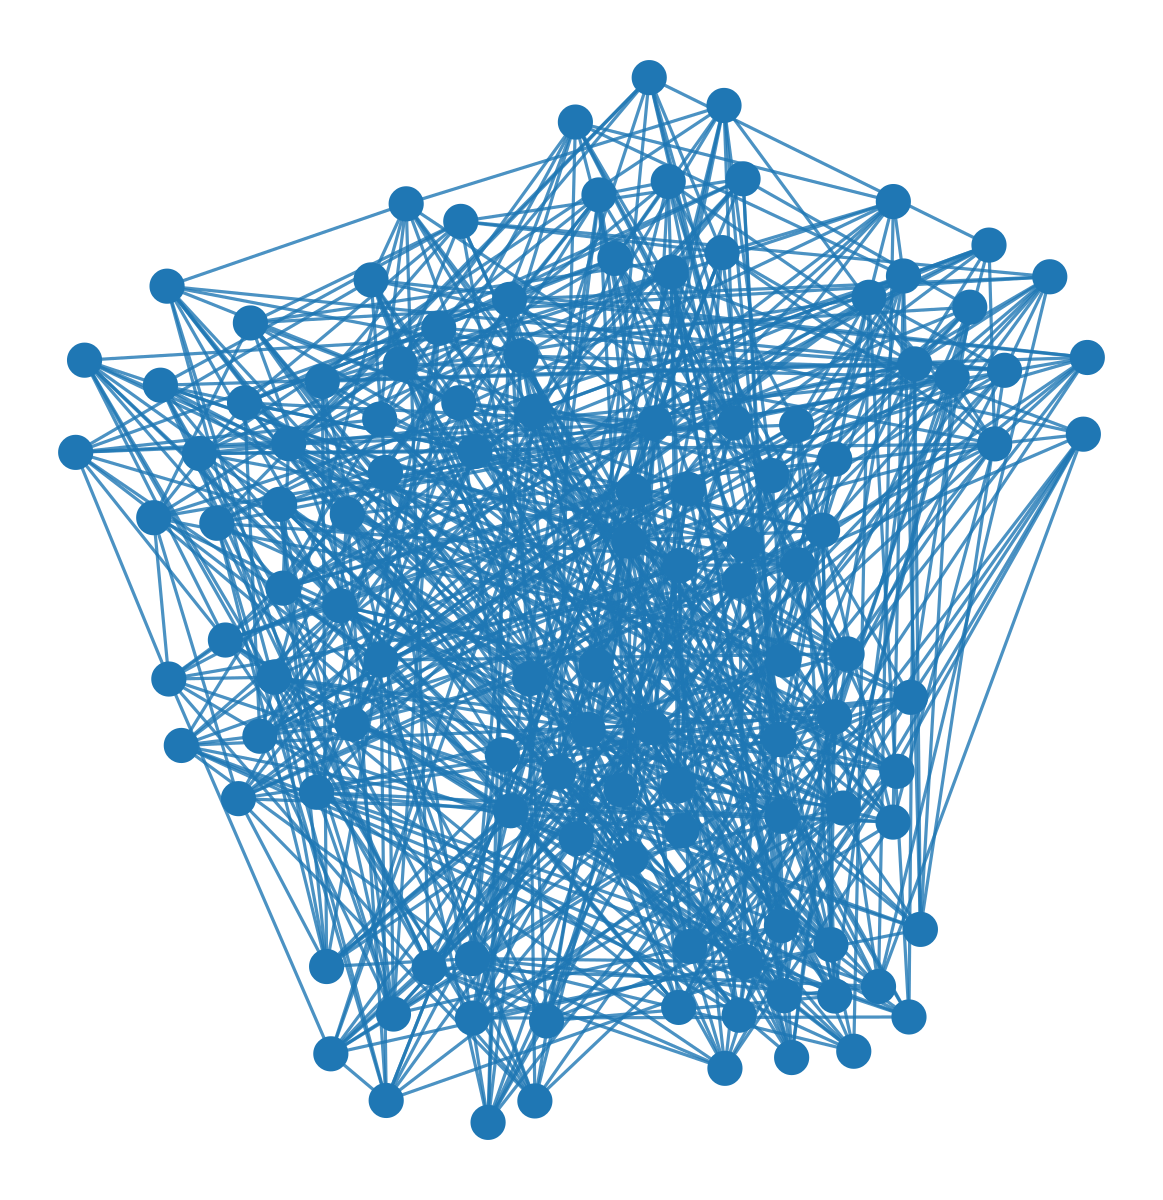

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc863696940, at 0x7fc830e94820>

In [12]:
state = PPBlockState(u)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=u.vp.pos)

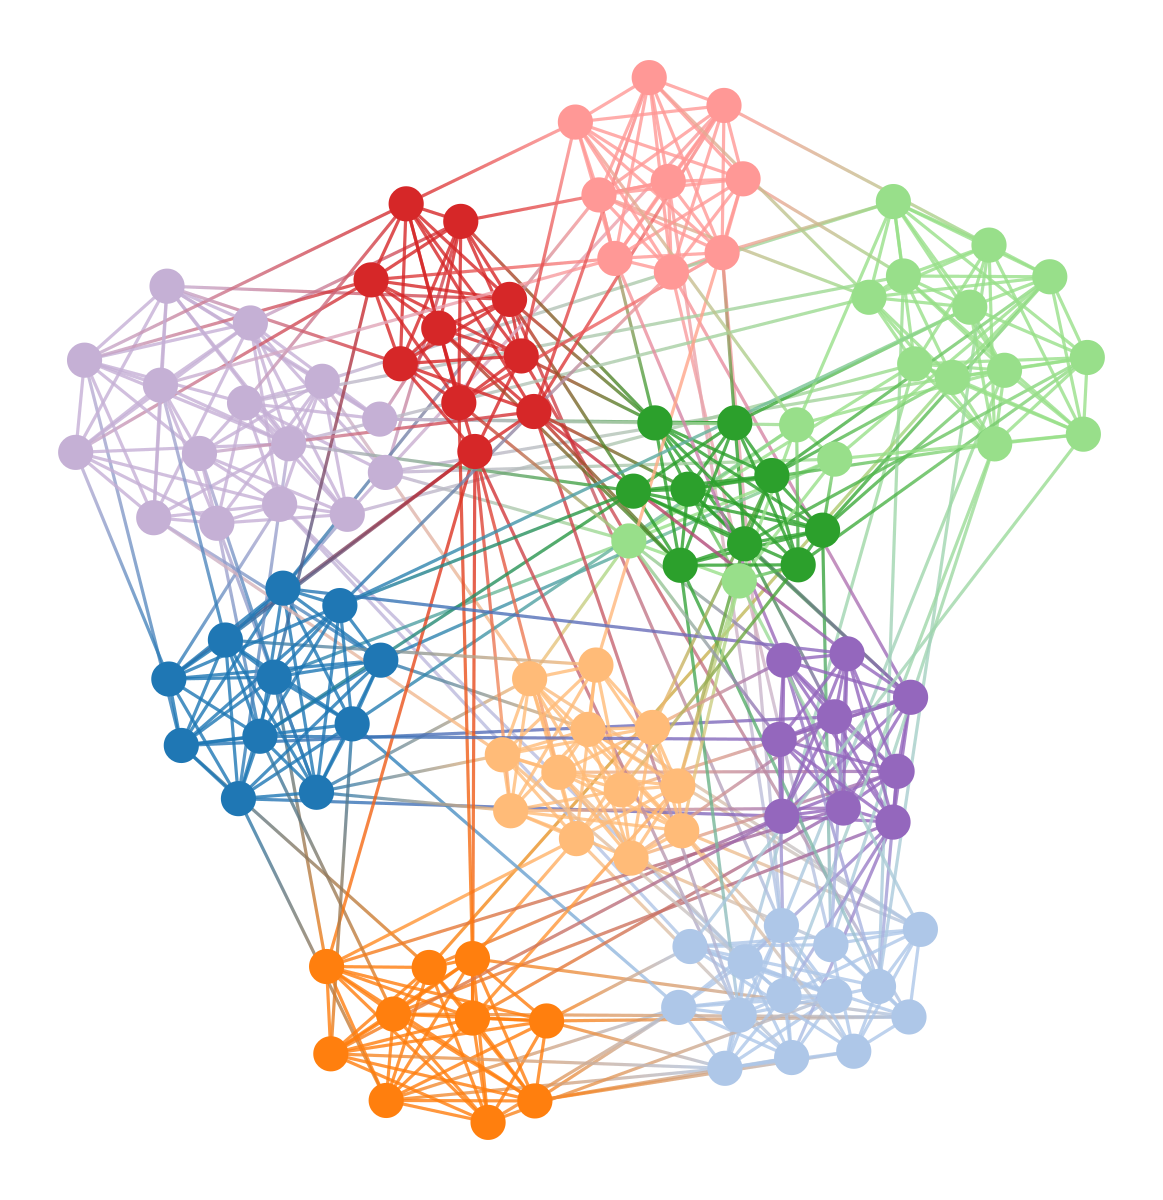

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc830e941f0, at 0x7fc830e94d30>

In [13]:
state = ModularityState(g)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=g.vp.pos)

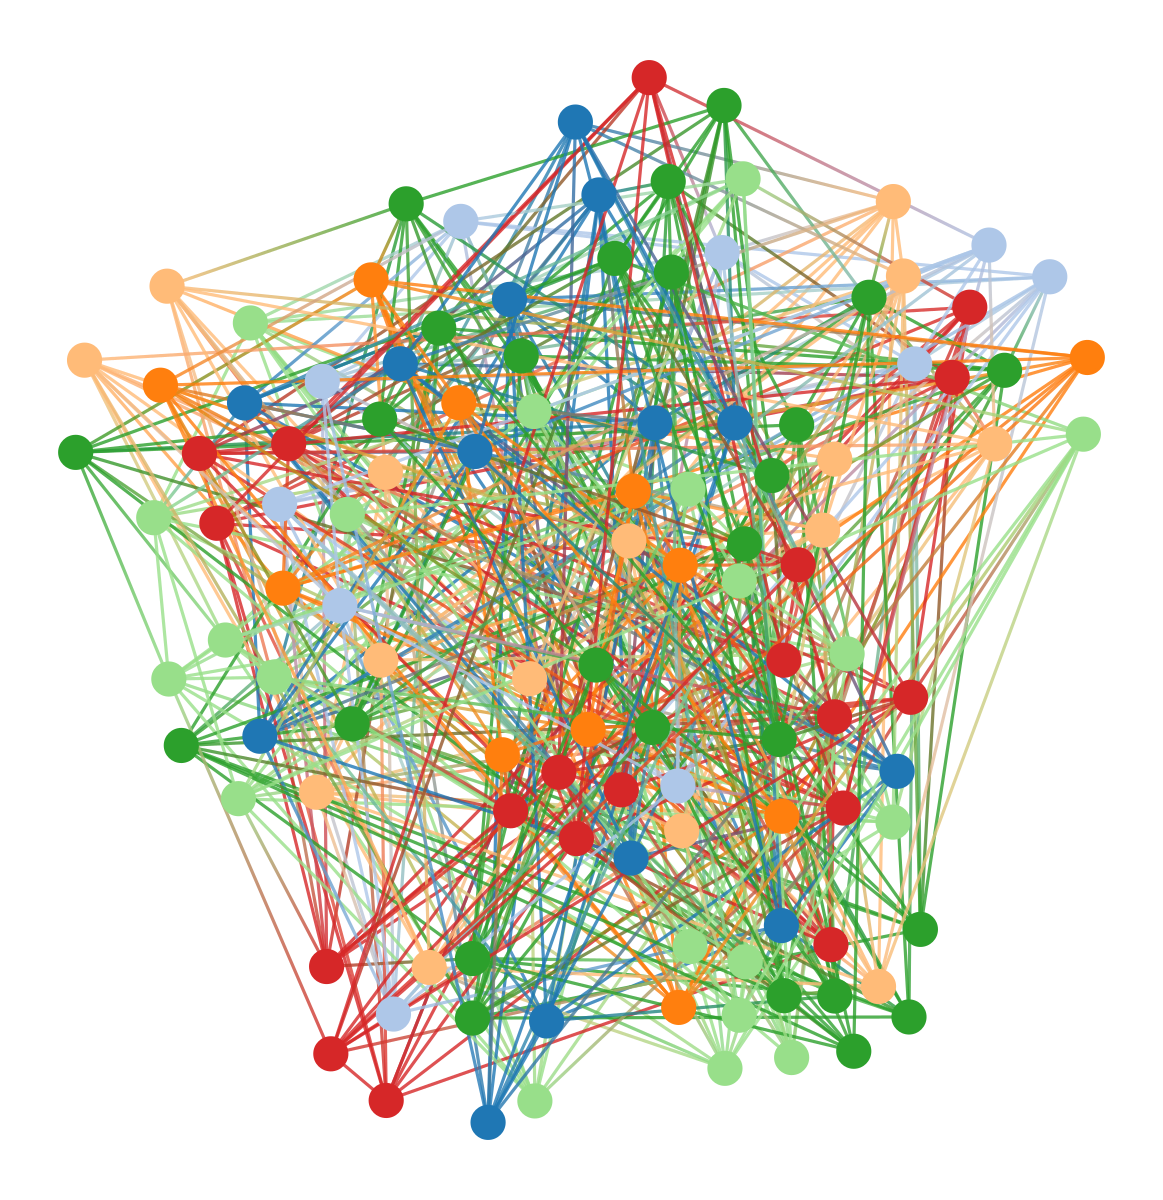

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc830e94d90, at 0x7fc830e943d0>

In [14]:
state = ModularityState(u)
state.multiflip_mcmc_sweep(niter=1000, beta=numpy.inf);
state.draw(pos=u.vp.pos)

# Homophily or triadic closure?

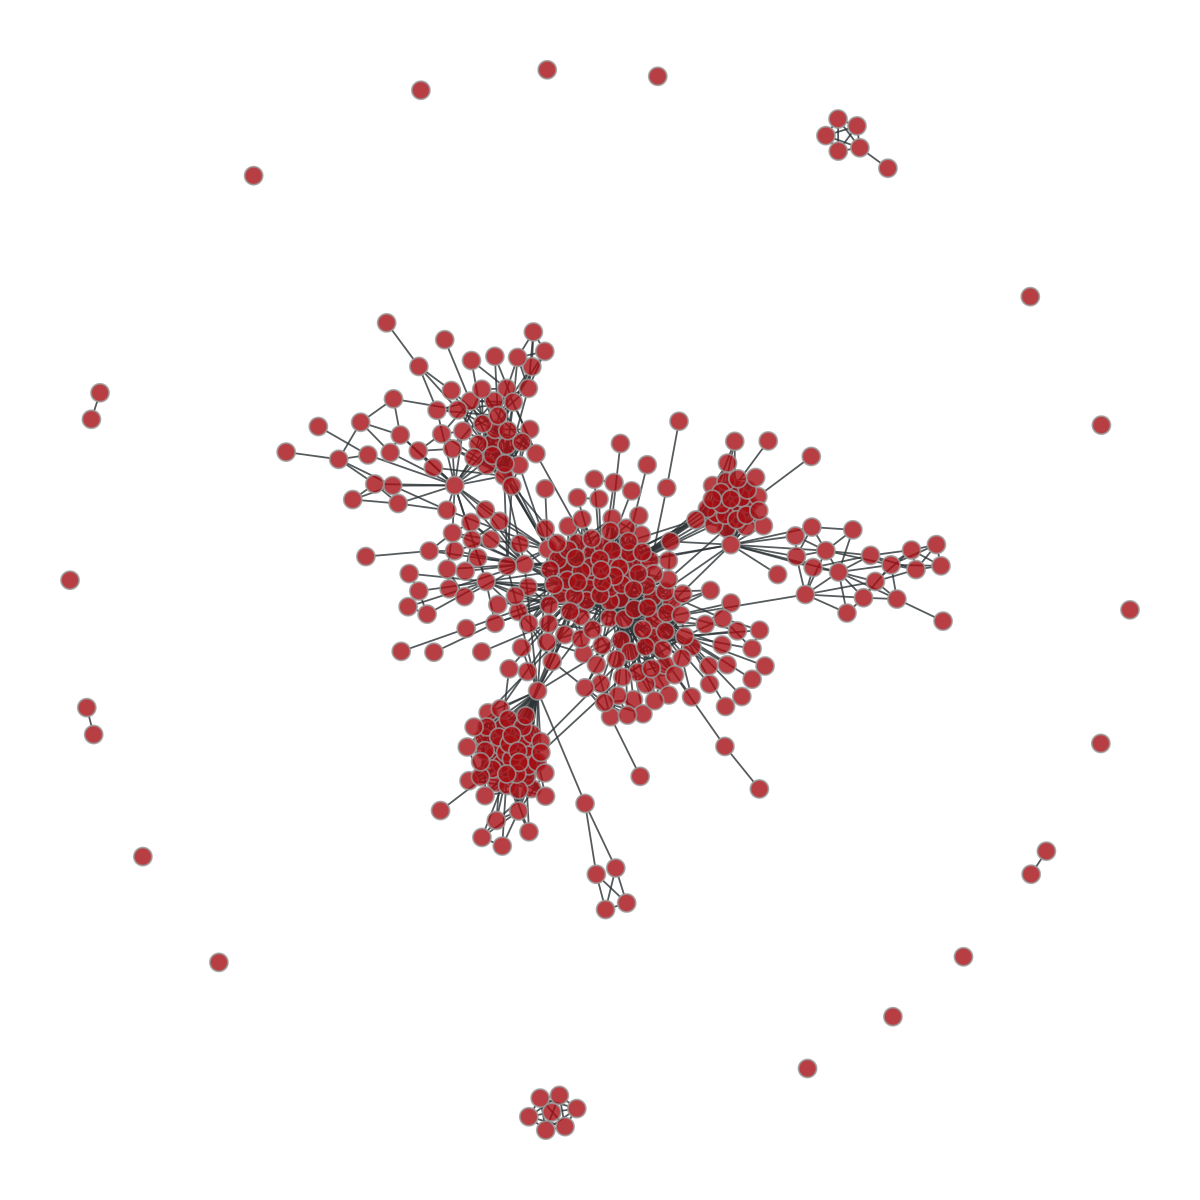

In [15]:
g = collection.ns["facebook_friends"]
graph_draw(g, g.vp._pos);

In [16]:
# We disentangle both mechanisms by using the SBM/TC model, as such

state = LatentClosureBlockState(g, L=6, nested=False)

#now we need to run MCMC

for i in range(1000):
    state.mcmc_sweep(niter=10)

In [17]:
# We ned to sample a bit from the posterior distribution

us = None             # marginal posterior graphs
bs = []               # partitions

for i in range(100):
    state.mcmc_sweep(niter=10)
    us = state.collect_marginal(us)
    bs.append(state.bstate.b.a.copy())

u = us[0]             # marginal seminal edges

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(u)

# Consider the marginal graph
bstate = state.bstate.copy(g=u)



0.01


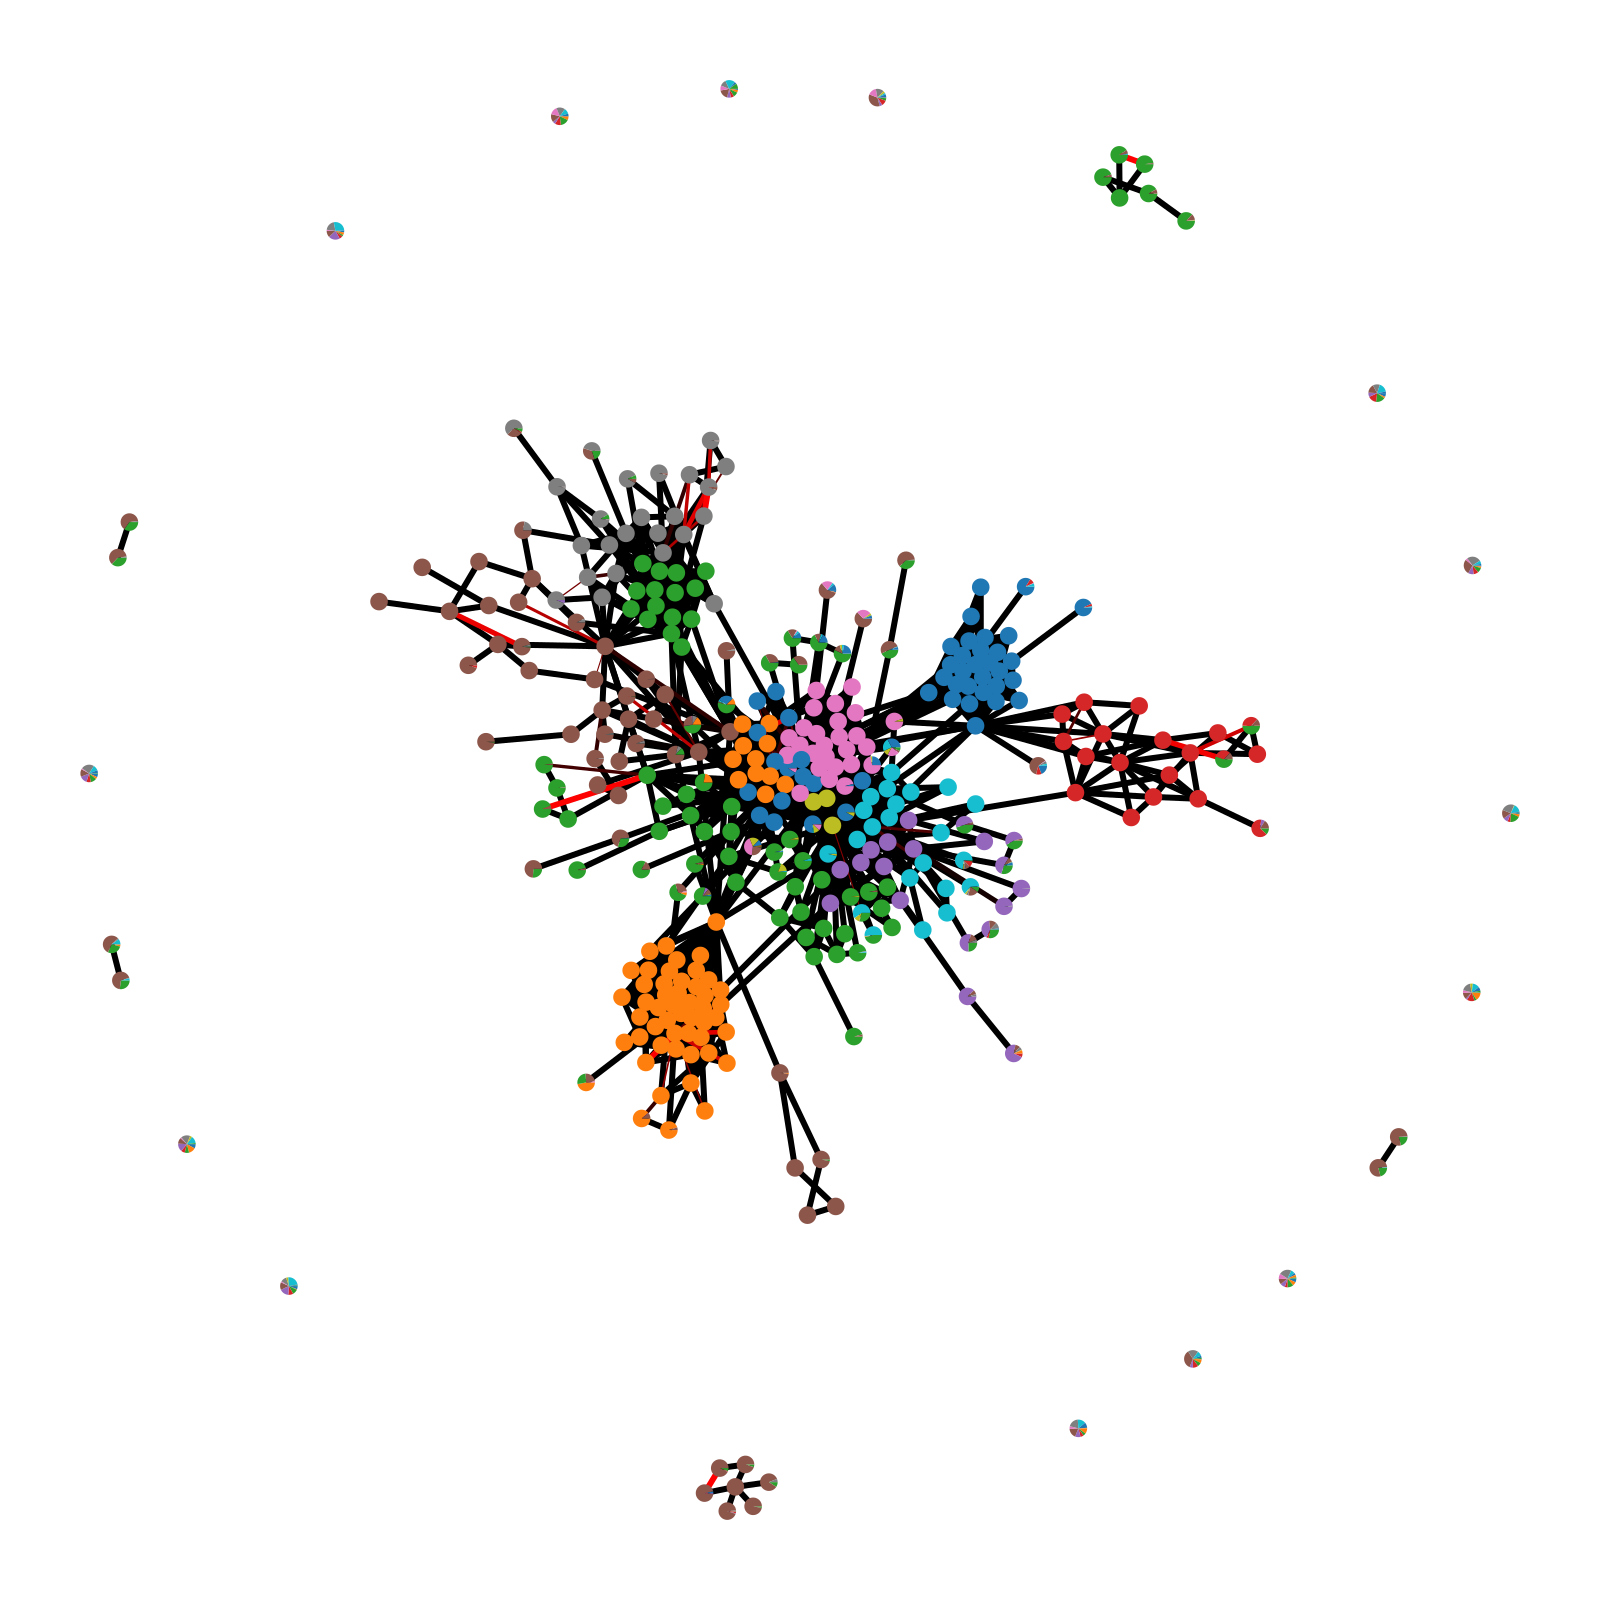

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc8636dfe20, at 0x7fc830eb40d0>

In [18]:
# let's visualize the results

import matplotlib.colors

# edge width
ew = u.ep.eprob.copy()
ew.a = abs(ew.a - .5)

# get a color map
clrs = [(1, 0, 0, 1.0),
        (0, 0, 0, 1.0)]
red_cm = matplotlib.colors.LinearSegmentedColormap.from_list("Set3", clrs)

# draw red edge last
eorder = u.ep.eprob.copy()
eorder.a *= -1

print(u.ep.eprob.fa.min())

bstate.draw(pos=u.own_property(g.vp._pos), vertex_shape="pie", vertex_pie_fractions=pv, vertex_size=8,
            edge_pen_width=prop_to_size(ew, .5, 3, power=1),
            edge_gradient=None, edge_color=u.ep.eprob, ecmap=red_cm,
            eorder=eorder, output_size=(800, 800))

In [19]:
#let's evaluate how much of homophily is responsible for triangle formation
print("Total network:", global_clustering(g))
u = state.us[0].copy()
remove_self_loops(u)
print("Homophilic layer:", global_clustering(u))

Total network: (0.5133740599216298, 0.0288857005736286)
Homophilic layer: (0.5130886056628253, 0.029007211029589856)


In [20]:
# A large fraction of triangles can be explained by homophily (in this case)!

## Excecise
Let the MCMC above run for a longer time, and observe the number of triadic closures to increase.


In [21]:
# We disentangle both mechanisms by using the SBM/TC model, as such

state = LatentClosureBlockState(g, L=6, nested=False)

#now we need to run MCMC

for i in range(5000):
    state.mcmc_sweep(niter=10)

In [22]:
# We ned to sample a bit from the posterior distribution

us = None             # marginal posterior graphs
bs = []               # partitions

for i in range(100):
    state.mcmc_sweep(niter=10)
    us = state.collect_marginal(us)
    bs.append(state.bstate.b.a.copy())

u = us[0]             # marginal seminal edges

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(u)

# Consider the marginal graph
bstate = state.bstate.copy(g=u)



0.01


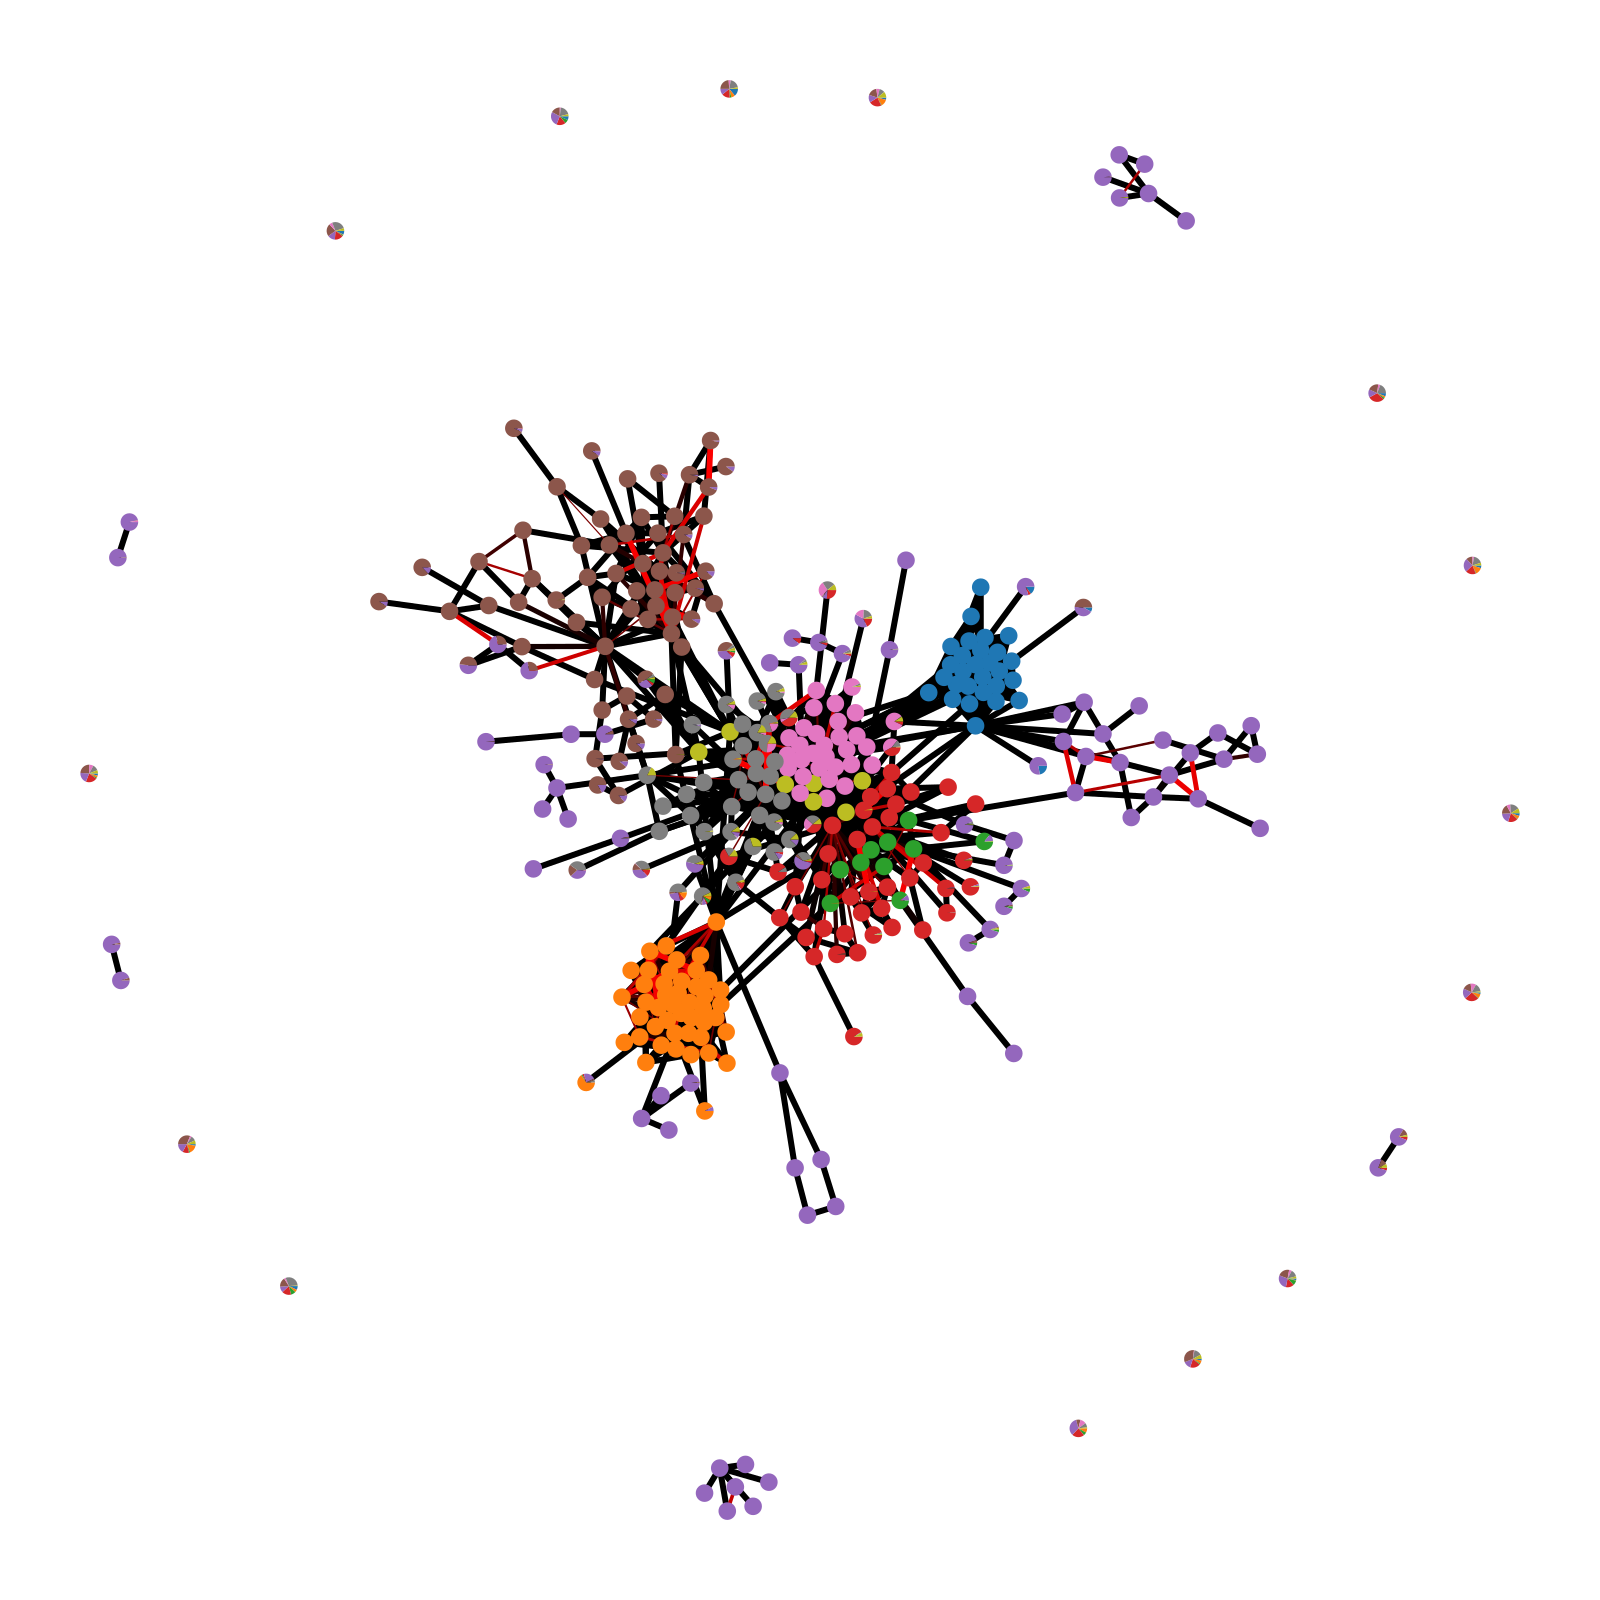

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc86378eb20, at 0x7fc830eb0130>

In [23]:
# let's visualize the results

import matplotlib.colors

# edge width
ew = u.ep.eprob.copy()
ew.a = abs(ew.a - .5)

# get a color map
clrs = [(1, 0, 0, 1.0),
        (0, 0, 0, 1.0)]
red_cm = matplotlib.colors.LinearSegmentedColormap.from_list("Set3", clrs)

# draw red edge last
eorder = u.ep.eprob.copy()
eorder.a *= -1

print(u.ep.eprob.fa.min())

bstate.draw(pos=u.own_property(g.vp._pos), vertex_shape="pie", vertex_pie_fractions=pv, vertex_size=8,
            edge_pen_width=prop_to_size(ew, .5, 3, power=1),
            edge_gradient=None, edge_color=u.ep.eprob, ecmap=red_cm,
            eorder=eorder, output_size=(800, 800))

In [24]:
#let's evaluate how much of homophily is responsible for triangle formation
print("Total network:", global_clustering(g))
u = state.us[0].copy()
remove_self_loops(u)
print("Homophilic layer:", global_clustering(u))

Total network: (0.5133740599216298, 0.0288857005736286)
Homophilic layer: (0.49340985053919406, 0.030324155305708627)
